# Basic Imports

In [1]:
from util import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb

c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Administrator/.netrc


In [6]:
del teacher, sampler_teacher, student, sampler_student, optimizer, scheduler
torch.cuda.empty_cache()

NameError: name 'teacher' is not defined

# Create teacher and student model

Both:

In [2]:
teacher, sampler_teacher, student, sampler_student = create_models(config_path, model_path, student=True)

Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


Only the student or teacher:

(setting student=False will only return a single model)

In [2]:
# teacher, sampler_teacher = create_models(config_path, model_path, student=False)
student, sampler_student = create_models(config_path, model_path, student=False)

Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


# Loading trained student as teacher

In [2]:
model_path_test = f"{cwd}/data/trained_models/10/student_intermediate_15.pt"
teacher, sampler_teacher, optimizer, scheduler = load_trained(model_path_test, config_path)

c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


## Generating WITHOUT intermediates saved

In [ ]:
img, x_T_copy, class_prompt, intermediates  = generate(teacher, sampler_teacher, steps=128, scale=3, keep_intermediates=False)
img

# Generating WITH intermediates saved

In [7]:
intermediates, starting_noise, class_prompt = return_intermediates_for_student(teacher, sampler_teacher, steps=250)

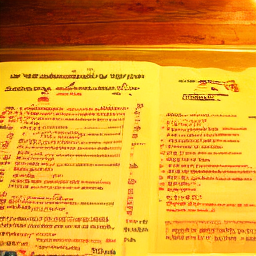

In [14]:
latent_to_img(teacher, intermediates[125])

# Creating a dataset

In [4]:
# dataset_path = f"{cwd}/data/pre_generated/teacher_128/"
# dataset_name = "teacher_128.pt"
# make_dataset(teacher, sampler_teacher, 501, 128, dataset_path, dataset_name)

100%|██████████| 500/500 [1:26:03<00:00, 10.33s/it]


# Training student from teacher directly

In [ ]:
wandb_session = wandb_log(name="test_loss", lr=1e-8, model=student, tags=["test"], notes="Just a test")

optimizer, scheduler = get_optimizer(sampler_student, iterations=20*20)
teacher_train_student(teacher, sampler_teacher, student, sampler_student, optimizer, scheduler, steps=20, generations=20, early_stop=True, session=wandb_session)

wandb.finish()

Extra, quick comparison:

In [ ]:
images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[8, 10, 12, 32])
images

In [5]:
steps = [1, 43, 66, 777, 999] 
[x / 1000 for x in steps]


[0.001, 0.043, 0.066, 0.777, 0.999]

In [ ]:
from util import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"


teacher, sampler_teacher, student, sampler_student = create_models(config_path, model_path, student=True)

optimizer, scheduler = get_optimizer(sampler_student, iterations=3*16)
teacher_train_student(teacher, sampler_teacher, student, sampler_student, optimizer, scheduler, steps=16, generations=6, early_stop=False, session=None)

images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[32, 16, 8, 4, 2, 1])


del teacher, sampler_teacher, student, sampler_student, optimizer, scheduler
torch.cuda.empty_cache()

images

In [6]:
del teacher, sampler_teacher, student, sampler_student, optimizer, scheduler
torch.cuda.empty_cache()

# Train student from pre-generated teacher dataset

In [3]:
data_dir = f"{cwd}/data/pre_generated/teacher_128/"
datasets = os.listdir(data_dir)

In [ ]:
notes = """This is a serious attempt to distill the 128 step original teacher into a 64 step student, trained on 32000 instances"""
wandb_session = wandb_log(name="Train_student_on_128_pretrained", lr=0.00000001, model=student, tags=["distillation"], notes=notes)

optimizer, scheduler = get_optimizer(sampler_student, iterations=64*500)

dataset = torch.load(data_dir + datasets[0])
train_student_from_dataset(student, sampler_student, dataset, 64, optimizer, scheduler, early_stop=True, session=wandb_session)

wandb.finish()

save_model(sampler_student, optimizer, scheduler, name="lr8_scheduled", steps=64)

# Save and Loading trained models

In [ ]:
save_model(sampler_student, optimizer, scheduler, name="lr8_scheduled", steps=64)

In [ ]:
path = f"{cwd}/data/trained_models/64/student_lr8_scheduled.pt"
student, sampler_student, optimizer, scheduler = load_trained(path, config_path)

# Direct Comparison

In [ ]:
images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[1, 2, 4, 8, 16, 32, 64, 128])
images



# Distillation Loop (allnighter)

In [ ]:
from util import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb

ddim_steps = [16, 8, 4, 2]
run_name = "True Attempt"
generations = 100
config = f"{cwd}/models/configs/cin256-v2-custom.yaml"
original_model_path = f"{cwd}/models/cin256_original.ckpt"
distill(ddim_steps, generations, run_name, config, original_model_path)

In [2]:
from util import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"


teacher, sampler_teacher, student, sampler_student = create_models(config_path, model_path, student=True)



MSEloss = nn.MSELoss()

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Administrator/.netrc


Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


RUN:  0 | Loss: 0.0002 | Loss: 39.3054 | Loss: 19.29777 | Loss: 16.24779 | Loss: 0.08429 | Loss: 238.03252 | Loss: 11.26302 | Loss: 27.36135 | Loss: 39.82115 | Loss: 0.12314 | Loss: 314.42535 | Loss: 6.34372 | Loss: 28.78999 | Loss: 82.42253 | Loss: 0.11865 | Loss: 1820.9082 | Loss: 162.81548 | Loss: 4.83939 | Loss: 4.00207 | Loss: 0.0866 | Loss: 345.90024 | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | Loss: nan | 

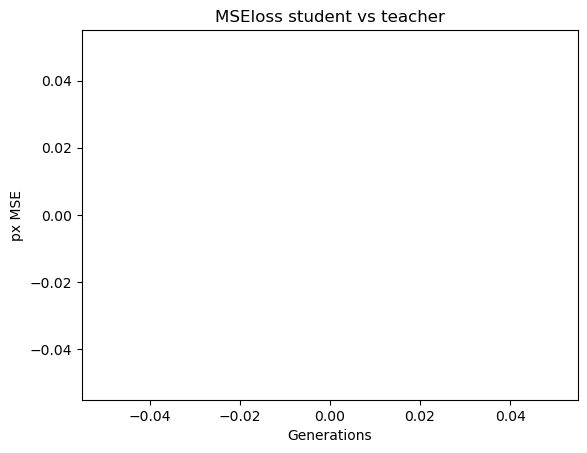

In [3]:
NUM_CLASSES = 1000
inst_per_distil = 1
generations = 10
ddim_steps_teacher = 10
ddim_steps_student = int(ddim_steps_teacher / 2)
TEACHER_STEPS = 2
STUDENT_STEPS = 1
ddim_eta = 0.0
scale = 3.0

updates = int(ddim_steps_teacher / TEACHER_STEPS)

all_samples = list()
averaged_losses = []

teacher_samples = list()
student_samples = list()



optimizer = torch.optim.Adam(sampler_student.model.parameters(), lr=0.1)#, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# optimizer = torch.optim.SGD(sampler_student.model.parameters(), lr=0.0001, momentum=0.9)


with torch.no_grad():
        for run in range(inst_per_distil):
                print("RUN: ", run, end=" | ")
                with teacher.ema_scope():
                        uc = teacher.get_learned_conditioning(
                                {teacher.cond_stage_key: torch.tensor(1*[1000]).to(teacher.device)}
                                )
                        for class_prompt in torch.randint(0, NUM_CLASSES, (generations,)):
                                losses = []
                        # for class_prompt in [1]:
                                sampler_teacher.make_schedule(ddim_num_steps=ddim_steps_teacher, ddim_eta=ddim_eta, verbose=False)
                                xc = torch.tensor([class_prompt])
                                c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
                                x_T = None
                                # optimizer.zero_grad()
                                sampler_student.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
                                c_student = student.get_learned_conditioning({student.cond_stage_key: xc.to(student.device)})
                                for steps in range(updates):
                                        
                                        # with torch.no_grad():
                                        # print("step:", steps)
                                        
                                        samples_ddim, teacher_intermediate, x_T_copy = sampler_teacher.sample(S=TEACHER_STEPS,
                                                                        conditioning=c,
                                                                        batch_size=1,
                                                                        shape=[3, 64, 64],
                                                                        verbose=False,
                                                                        x_T=x_T,
                                                                        unconditional_guidance_scale=scale,
                                                                        unconditional_conditioning=uc, 
                                                                        eta=ddim_eta,
                                                                        keep_intermediates=True,
                                                                        intermediate_step = steps*TEACHER_STEPS,
                                                                        steps_per_sampling = TEACHER_STEPS,
                                                                        total_steps = ddim_steps_teacher)
                                        x_T = teacher_intermediate["x_inter"][-1]

                                        with torch.enable_grad():
                                                        
                                                optimizer.zero_grad()
                                                samples_ddim_student, student_intermediate, x_T_copy, = sampler_student.sample_student(S=STUDENT_STEPS,
                                                                                conditioning=c_student,
                                                                                batch_size=1,
                                                                                shape=[3, 64, 64],
                                                                                verbose=False,
                                                                                x_T=x_T_copy,
                                                                                unconditional_guidance_scale=scale,
                                                                                unconditional_conditioning=uc, 
                                                                                eta=ddim_eta,
                                                                                keep_intermediates=True,
                                                                                intermediate_step = steps*STUDENT_STEPS,
                                                                                steps_per_sampling = STUDENT_STEPS,
                                                                                total_steps = ddim_steps_student)
                                                
                                                x_T_student = student_intermediate["x_inter"][-1]
                                        
                                                
                                                
                                                
                                                # x_T_student.requires_grad = True
                                                # loss = mse_loss(x_T_student, x_T)
                                                loss = MSEloss(x_T_student, x_T)
                                                # loss = MSEloss(samples_ddim_student.flatten(), samples_ddim.flatten())
                                                
                                                print("Loss:", round(loss.item(), 5), end= " | ")
                                                # print("loss", loss)
                                                # print("backward!")
                                                loss.backward()
                                                
                                                optimizer.step()
                                                
                                                losses.append(loss.item())
                                                # optimizer.zero_grad()
                                
                                        

                        # print("Loss: ", round(sum(losses) / len(losses), 5), end= " - ")
                        averaged_losses.append(sum(losses) / len(losses))

                        x_samples_ddim = teacher.decode_first_stage(x_T)
                        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
                        teacher_samples.append(x_samples_ddim)

                        x_samples_ddim = student.decode_first_stage(x_T_student)
                        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
                        teacher_samples.append(x_samples_ddim)
                                                        

plt.plot(range(len(averaged_losses)), averaged_losses, label="MSE LOSS")
plt.xlabel("Generations")
plt.ylabel("px MSE")
plt.title("MSEloss student vs teacher")
plt.show()

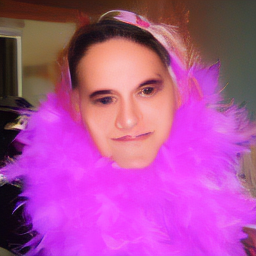

In [3]:
x_samples_ddim = teacher.decode_first_stage(teacher_intermediate["x_inter"][-1])
x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
grid = rearrange(x_samples_ddim, 'b c h w -> (b) c h w')
grid = make_grid(grid, nrow=1)
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8)) 

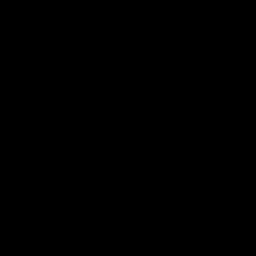

In [4]:
x_samples_ddim = student.decode_first_stage(student_intermediate["x_inter"][-1])
x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
grid = rearrange(x_samples_ddim, 'b c h w -> (b) c h w')
grid = make_grid(grid, nrow=1)
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8)) 